In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay


In [0]:

    x1 = tri[0].x
    y1 = tri[0].y
    x2 = tri[1].x
    y2 = tri[1].y
    x3 = tri[2].x
    y3 = tri[2].y
    if (y2-y1)/(x2-x1)*noeud.x - (y2-y1)/(x2-x1)*x1 + y1 - noeud.y > 0 :
        if (y3-y2)/(x3-x2)*noeud.x - (y3-y2)/(x3-x2)*x2 + y2 - noeud.y > 0 :
            if (y1-y3)/(x1-x3)*noeud.x - (y1-y3)/(x2-x3)*x3 + y3 - noeud.y > 0 :
                return True
    return False


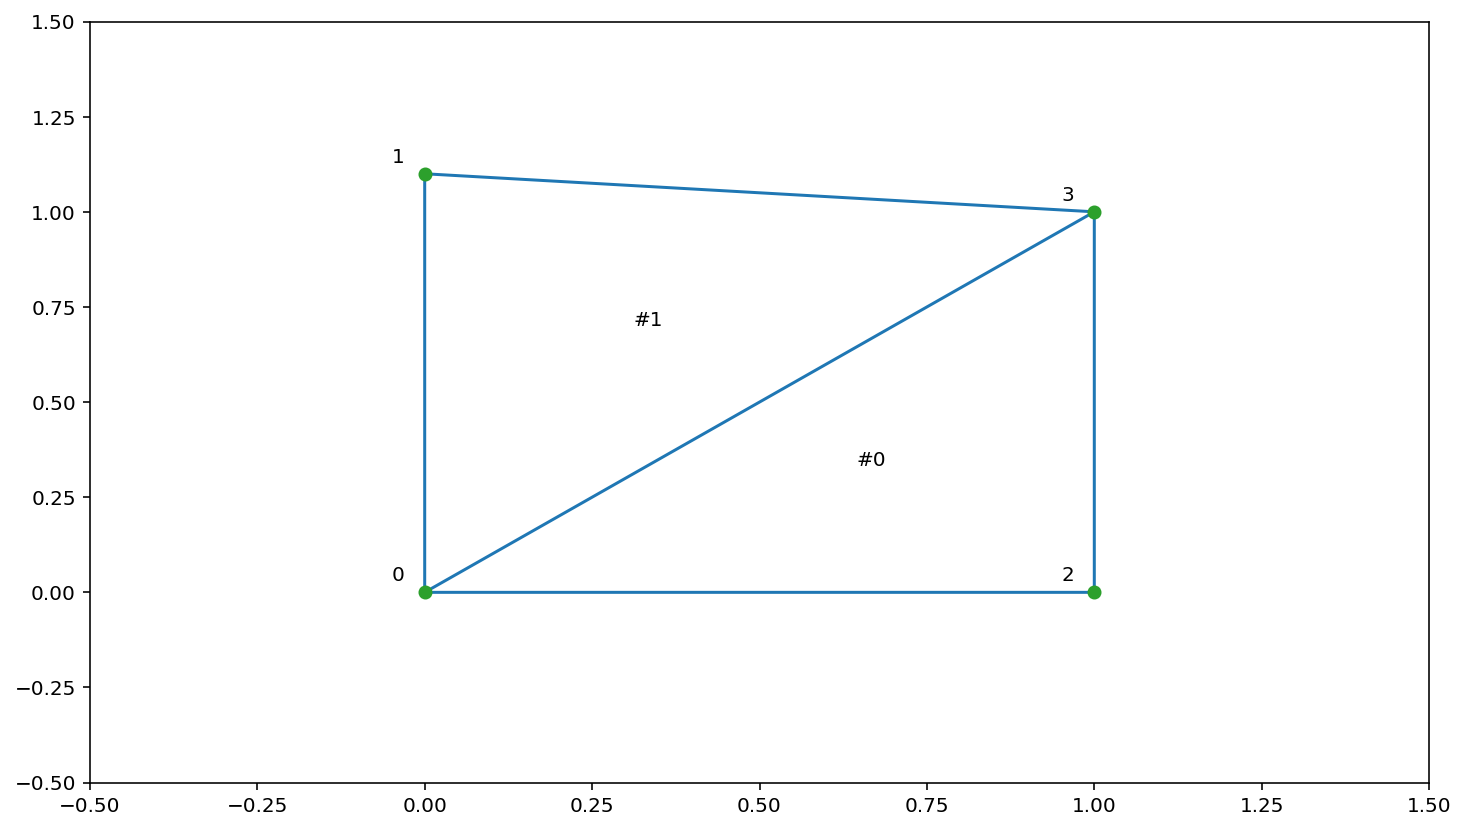

array([[1. , 1. ],
       [0. , 1.1],
       [0. , 0. ]])

In [3]:
points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])
tri = Delaunay(points)
import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
for j, p in enumerate(points):
    plt.text(p[0]-0.03, p[1]+0.03, j, ha='right') # label the points
for j, s in enumerate(tri.simplices):
    p = points[s].mean(axis=0)
    plt.text(p[0], p[1], '#%d' % j, ha='center') # label triangles
plt.xlim(-0.5, 1.5); plt.ylim(-0.5, 1.5)
plt.show()
i = 1
tri.simplices[i,:]
np.array([3, 1, 0])
points[tri.simplices[i,:]]
np.array([[ 1. ,  1. ],
       [ 0. ,  1.1],
       [ 0. ,  0. ]])

In [4]:
import numpy as np
from math import sqrt


class Delaunay2D:
    """
    Class to compute a Delaunay triangulation in 2D
    ref: http://en.wikipedia.org/wiki/Bowyer-Watson_algorithm
    ref: http://www.geom.uiuc.edu/~samuelp/del_project.html
    """

    def __init__(self, center=(0, 0), radius=9999):
        """ Init and create a new frame to contain the triangulation
        center -- Optional position for the center of the frame. Default (0,0)
        radius -- Optional distance from corners to the center.
        """
        center = np.asarray(center)
        # Create coordinates for the corners of the frame
        self.coords = [center+radius*np.array((-1, -1)),
                       center+radius*np.array((+1, -1)),
                       center+radius*np.array((+1, +1)),
                       center+radius*np.array((-1, +1))]

        # Create two dicts to store triangle neighbours and circumcircles.
        self.triangles = {}
        self.circles = {}

        # Create two CCW triangles for the frame
        T1 = (0, 1, 3)
        T2 = (2, 3, 1)
        self.triangles[T1] = [T2, None, None]
        self.triangles[T2] = [T1, None, None]

        # Compute circumcenters and circumradius for each triangle
        for t in self.triangles:
            self.circles[t] = self.circumcenter(t)

    def circumcenter(self, tri):
        """Compute circumcenter and circumradius of a triangle in 2D.
        Uses an extension of the method described here:
        http://www.ics.uci.edu/~eppstein/junkyard/circumcenter.html
        """
        pts = np.asarray([self.coords[v] for v in tri])
        pts2 = np.dot(pts, pts.T)
        A = np.bmat([[2 * pts2, [[1],
                                 [1],
                                 [1]]],
                      [[[1, 1, 1, 0]]]])

        b = np.hstack((np.sum(pts * pts, axis=1), [1]))
        x = np.linalg.solve(A, b)
        bary_coords = x[:-1]
        center = np.dot(bary_coords, pts)

        # radius = np.linalg.norm(pts[0] - center) # euclidean distance
        radius = np.sum(np.square(pts[0] - center))  # squared distance
        return (center, radius)

    def inCircleFast(self, tri, p):
        """Check if point p is inside of precomputed circumcircle of tri.
        """
        center, radius = self.circles[tri]
        return np.sum(np.square(center - p)) <= radius

    def inCircleRobust(self, tri, p):
        """Check if point p is inside of circumcircle around the triangle tri.
        This is a robust predicate, slower than compare distance to centers
        ref: http://www.cs.cmu.edu/~quake/robust.html
        """
        m1 = np.asarray([self.coords[v] - p for v in tri])
        m2 = np.sum(np.square(m1), axis=1).reshape((3, 1))
        m = np.hstack((m1, m2))    # The 3x3 matrix to check
        return np.linalg.det(m) <= 0

    def addPoint(self, p):
        """Add a point to the current DT, and refine it using Bowyer-Watson.
        """
        p = np.asarray(p)
        idx = len(self.coords)
        # print("coords[", idx,"] ->",p)
        self.coords.append(p)

        # Search the triangle(s) whose circumcircle contains p
        bad_triangles = []
        for T in self.triangles:
            # Choose one method: inCircleRobust(T, p) or inCircleFast(T, p)
            if self.inCircleFast(T, p):
                bad_triangles.append(T)

        # Find the CCW boundary (star shape) of the bad triangles,
        # expressed as a list of edges (point pairs) and the opposite
        # triangle to each edge.
        boundary = []
        # Choose a "random" triangle and edge
        T = bad_triangles[0]
        edge = 0
        # get the opposite triangle of this edge
        while True:
            # Check if edge of triangle T is on the boundary...
            # if opposite triangle of this edge is external to the list
            tri_op = self.triangles[T][edge]
            if tri_op not in bad_triangles:
                # Insert edge and external triangle into boundary list
                boundary.append((T[(edge+1) % 3], T[(edge-1) % 3], tri_op))

                # Move to next CCW edge in this triangle
                edge = (edge + 1) % 3

                # Check if boundary is a closed loop
                if boundary[0][0] == boundary[-1][1]:
                    break
            else:
                # Move to next CCW edge in opposite triangle
                edge = (self.triangles[tri_op].index(T) + 1) % 3
                T = tri_op

        # Remove triangles too near of point p of our solution
        for T in bad_triangles:
            del self.triangles[T]
            del self.circles[T]

        # Retriangle the hole left by bad_triangles
        new_triangles = []
        for (e0, e1, tri_op) in boundary:
            # Create a new triangle using point p and edge extremes
            T = (idx, e0, e1)

            # Store circumcenter and circumradius of the triangle
            self.circles[T] = self.circumcenter(T)

            # Set opposite triangle of the edge as neighbour of T
            self.triangles[T] = [tri_op, None, None]

            # Try to set T as neighbour of the opposite triangle
            if tri_op:
                # search the neighbour of tri_op that use edge (e1, e0)
                for i, neigh in enumerate(self.triangles[tri_op]):
                    if neigh:
                        if e1 in neigh and e0 in neigh:
                            # change link to use our new triangle
                            self.triangles[tri_op][i] = T

            # Add triangle to a temporal list
            new_triangles.append(T)

        # Link the new triangles each another
        N = len(new_triangles)
        for i, T in enumerate(new_triangles):
            self.triangles[T][1] = new_triangles[(i+1) % N]   # next
            self.triangles[T][2] = new_triangles[(i-1) % N]   # previous

    def exportTriangles(self):
        """Export the current list of Delaunay triangles
        """
        # Filter out triangles with any vertex in the extended BBox
        return [(a-4, b-4, c-4)
                for (a, b, c) in self.triangles if a > 3 and b > 3 and c > 3]

    def exportCircles(self):
        """Export the circumcircles as a list of (center, radius)
        """
        # Remember to compute circumcircles if not done before
        # for t in self.triangles:
        #     self.circles[t] = self.circumcenter(t)

        # Filter out triangles with any vertex in the extended BBox
        # Do sqrt of radius before of return
        return [(self.circles[(a, b, c)][0], sqrt(self.circles[(a, b, c)][1]))
                for (a, b, c) in self.triangles if a > 3 and b > 3 and c > 3]

    def exportDT(self):
        """Export the current set of Delaunay coordinates and triangles.
        """
        # Filter out coordinates in the extended BBox
        coord = self.coords[4:]

        # Filter out triangles with any vertex in the extended BBox
        tris = [(a-4, b-4, c-4)
                for (a, b, c) in self.triangles if a > 3 and b > 3 and c > 3]
        return coord, tris

    def exportExtendedDT(self):
        """Export the Extended Delaunay Triangulation (with the frame vertex).
        """
        return self.coords, list(self.triangles)

    def exportVoronoiRegions(self):
        """Export coordinates and regions of Voronoi diagram as indexed data.
        """
        # Remember to compute circumcircles if not done before
        # for t in self.triangles:
        #     self.circles[t] = self.circumcenter(t)
        useVertex = {i: [] for i in range(len(self.coords))}
        vor_coors = []
        index = {}
        # Build a list of coordinates and one index per triangle/region
        for tidx, (a, b, c) in enumerate(sorted(self.triangles)):
            vor_coors.append(self.circles[(a, b, c)][0])
            # Insert triangle, rotating it so the key is the "last" vertex
            useVertex[a] += [(b, c, a)]
            useVertex[b] += [(c, a, b)]
            useVertex[c] += [(a, b, c)]
            # Set tidx as the index to use with this triangle
            index[(a, b, c)] = tidx
            index[(c, a, b)] = tidx
            index[(b, c, a)] = tidx

        # init regions per coordinate dictionary
        regions = {}
        # Sort each region in a coherent order, and substitude each triangle
        # by its index
        for i in range(4, len(self.coords)):
            v = useVertex[i][0][0]  # Get a vertex of a triangle
            r = []
            for _ in range(len(useVertex[i])):
                # Search the triangle beginning with vertex v
                t = [t for t in useVertex[i] if t[0] == v][0]
                r.append(index[t])  # Add the index of this triangle to region
                v = t[1]            # Choose the next vertex to search
            regions[i-4] = r        # Store region.

        return vor_coors, regions

seeds:
 [[23.86486902 32.35653848]
 [30.2544636   5.57534317]
 [17.77153818 91.10442357]
 [95.55673407  7.06726955]
 [98.24218317 42.93864625]
 [96.59227236 50.34698277]
 [93.89780264 73.92089403]
 [64.3863959  22.91090879]
 [50.60646709 69.32524783]
 [43.76607991 53.66291174]
 [61.57004756 50.39079966]
 [ 5.68985868 84.17282543]
 [ 9.82066718 61.19045572]
 [60.91885142 32.43932785]
 [14.8965173  24.35091454]
 [46.27450266 11.92077966]
 [12.55682495 31.72886368]
 [74.1189803  51.7306997 ]
 [95.79677881 45.30946573]
 [86.04768028 29.24224826]
 [35.05952049 75.41718284]
 [60.65314598 96.25206652]
 [26.68587371 44.34332145]
 [14.83257512 26.33437631]]
BBox Min: [5.68985868 5.57534317] Bbox Max:  [98.24218317 96.25206652]
37 Delaunay triangles


ValueError: Image size of 75346x75338 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 864x504 with 1 Axes>

Inserting seed 0 [23.86486902 32.35653848]
Inserting seed 1 [30.2544636   5.57534317]
Inserting seed 2 [17.77153818 91.10442357]


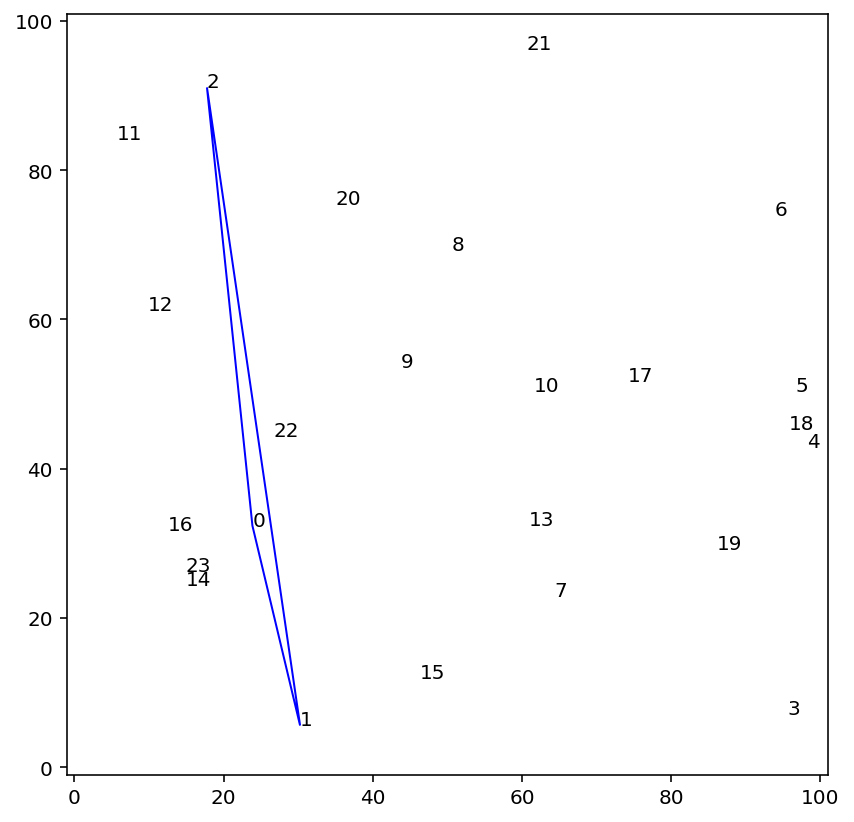

Inserting seed 3 [95.55673407  7.06726955]


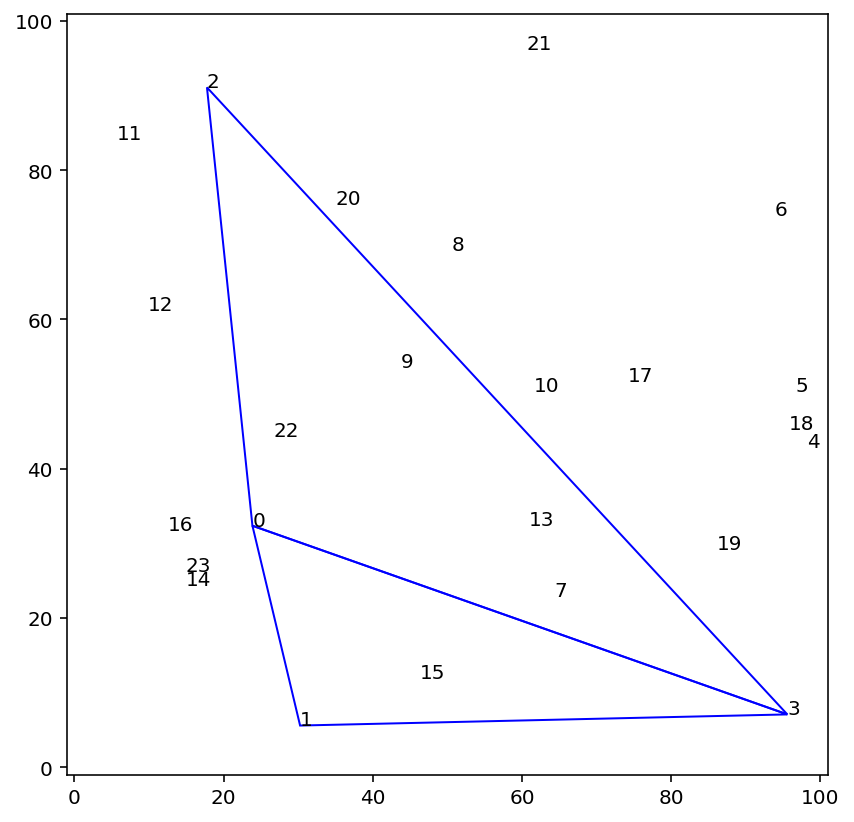

Inserting seed 4 [98.24218317 42.93864625]


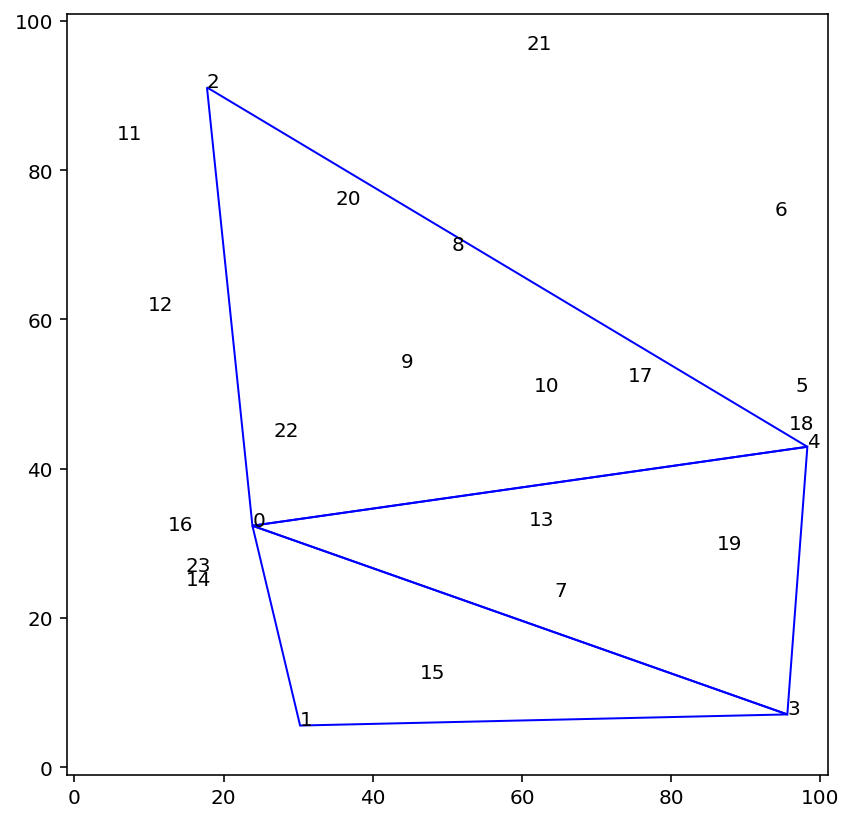

Inserting seed 5 [96.59227236 50.34698277]


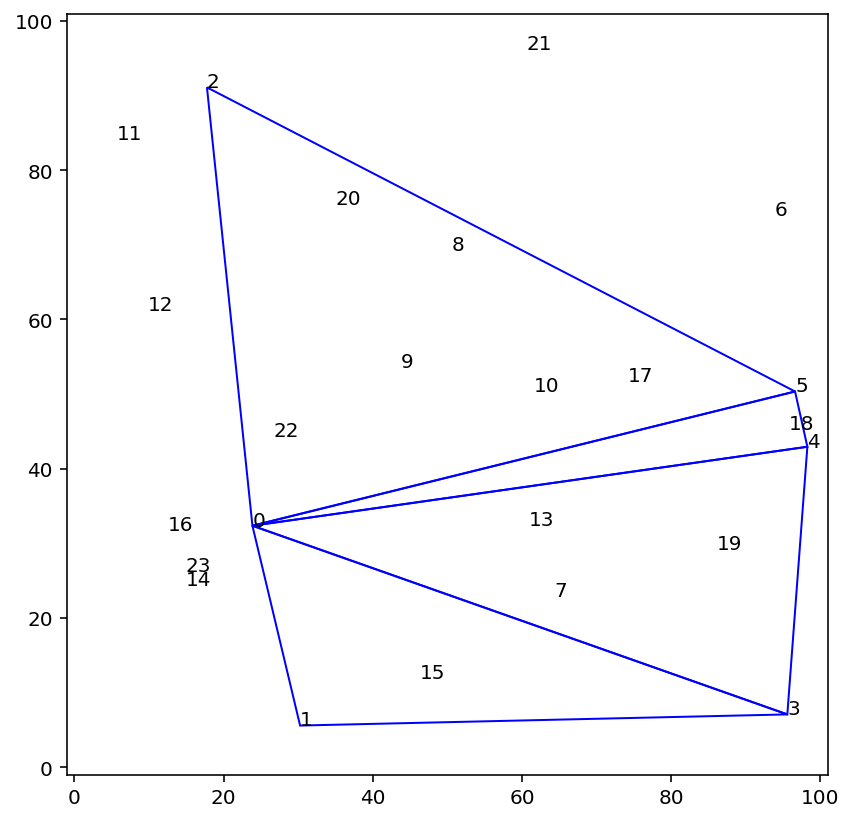

Inserting seed 6 [93.89780264 73.92089403]


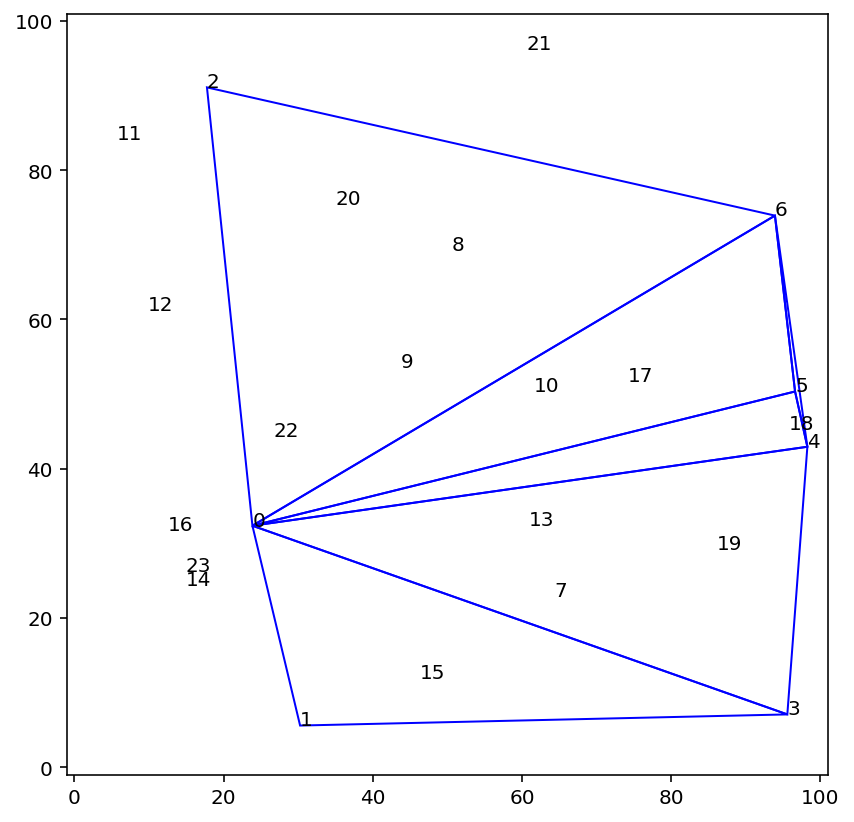

Inserting seed 7 [64.3863959  22.91090879]


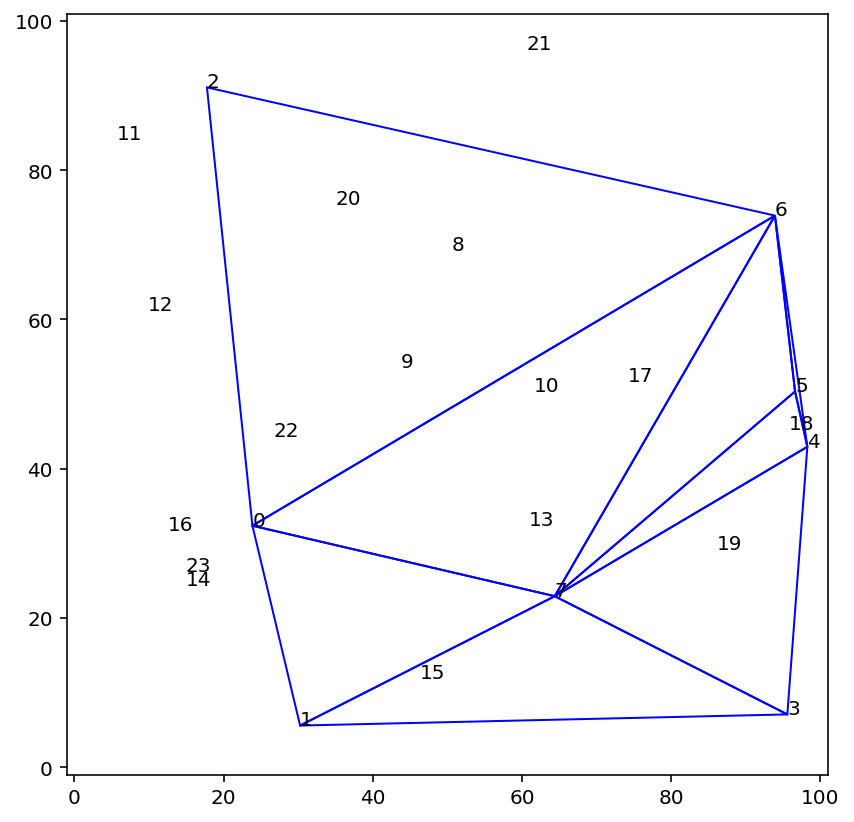

Inserting seed 8 [50.60646709 69.32524783]


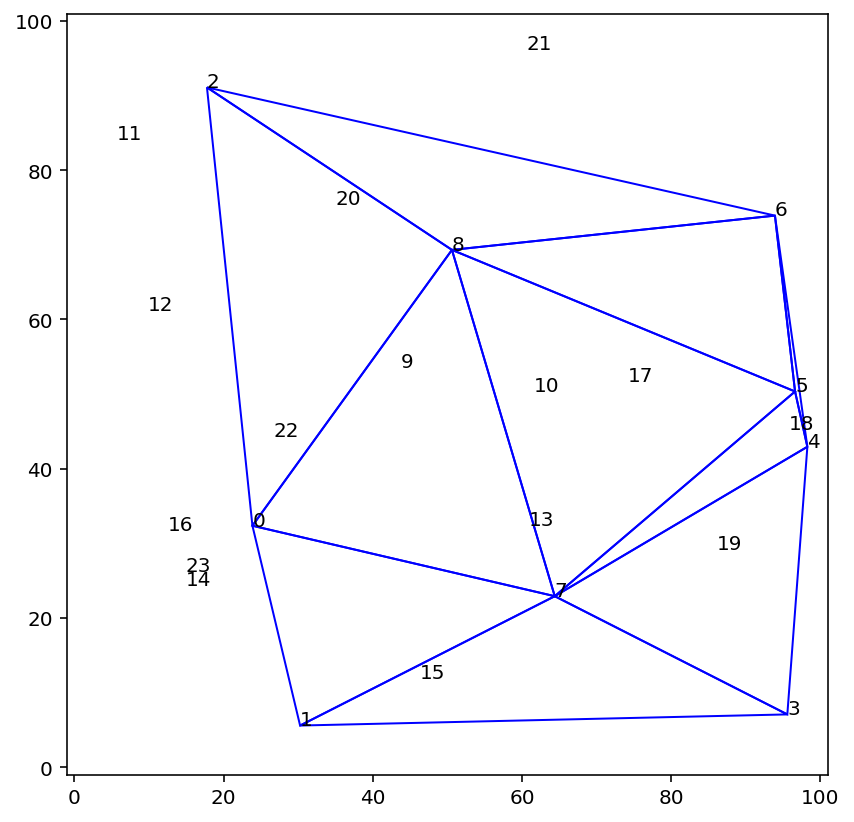

Inserting seed 9 [43.76607991 53.66291174]


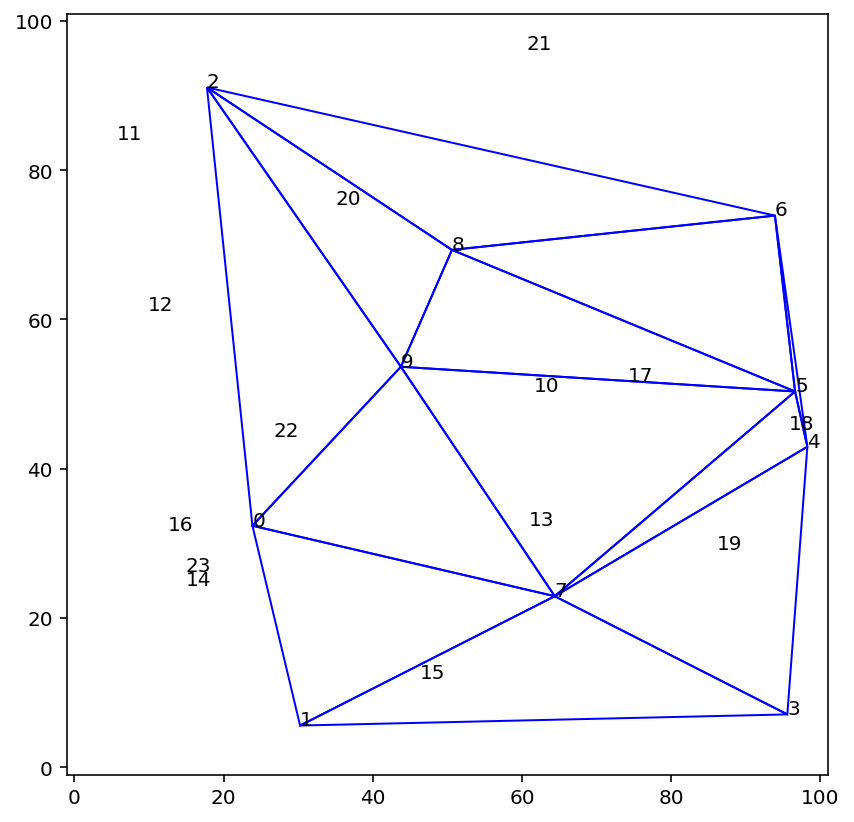

Inserting seed 10 [61.57004756 50.39079966]


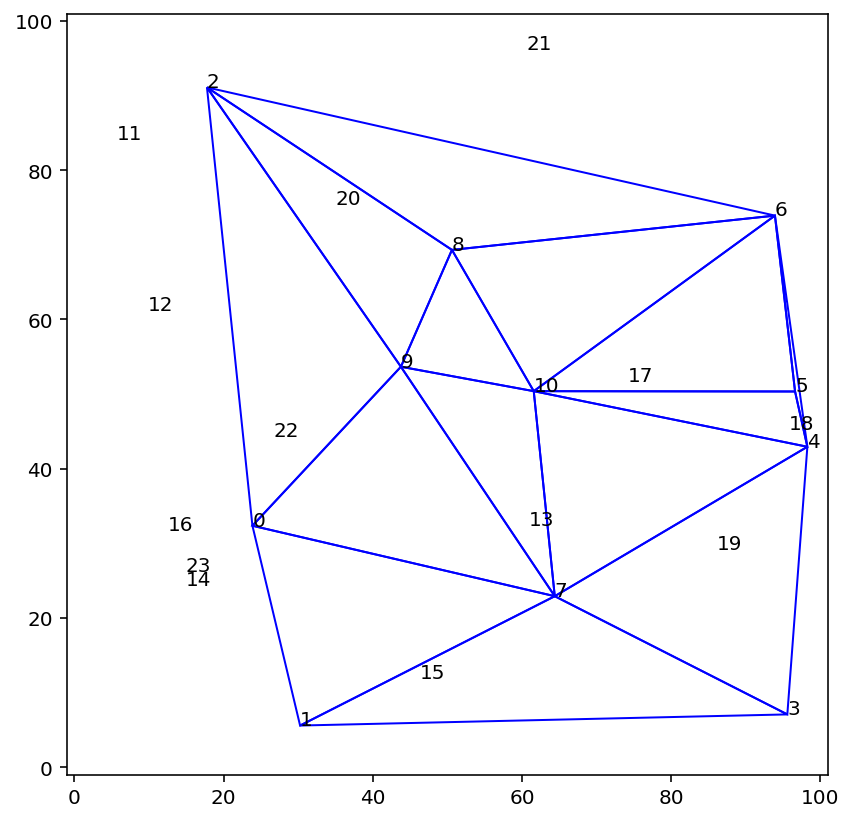

Inserting seed 11 [ 5.68985868 84.17282543]


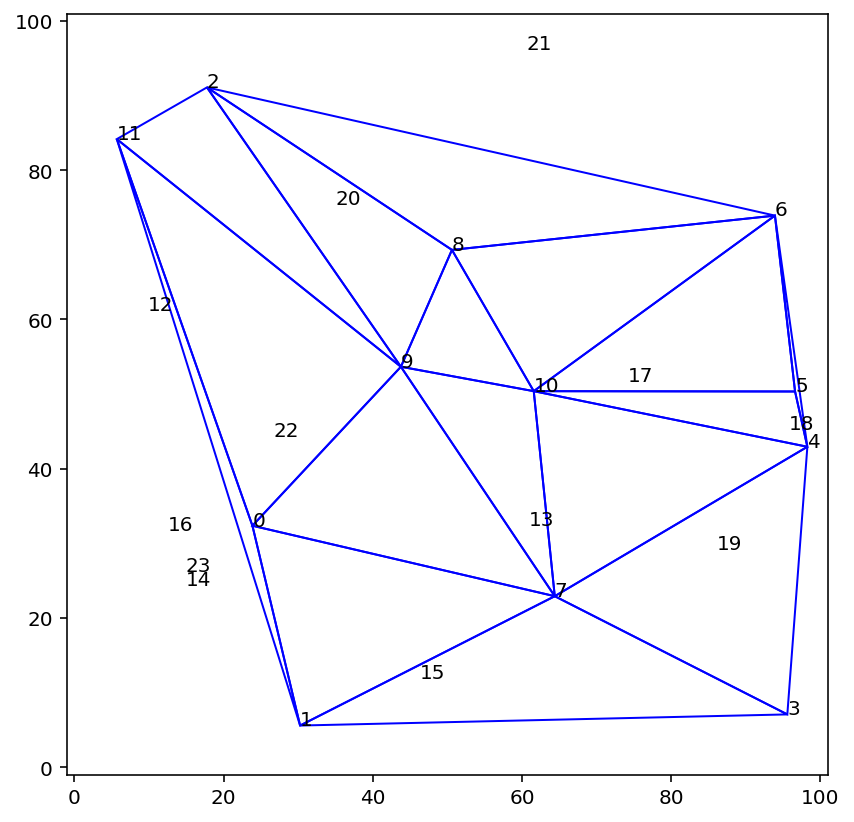

Inserting seed 12 [ 9.82066718 61.19045572]


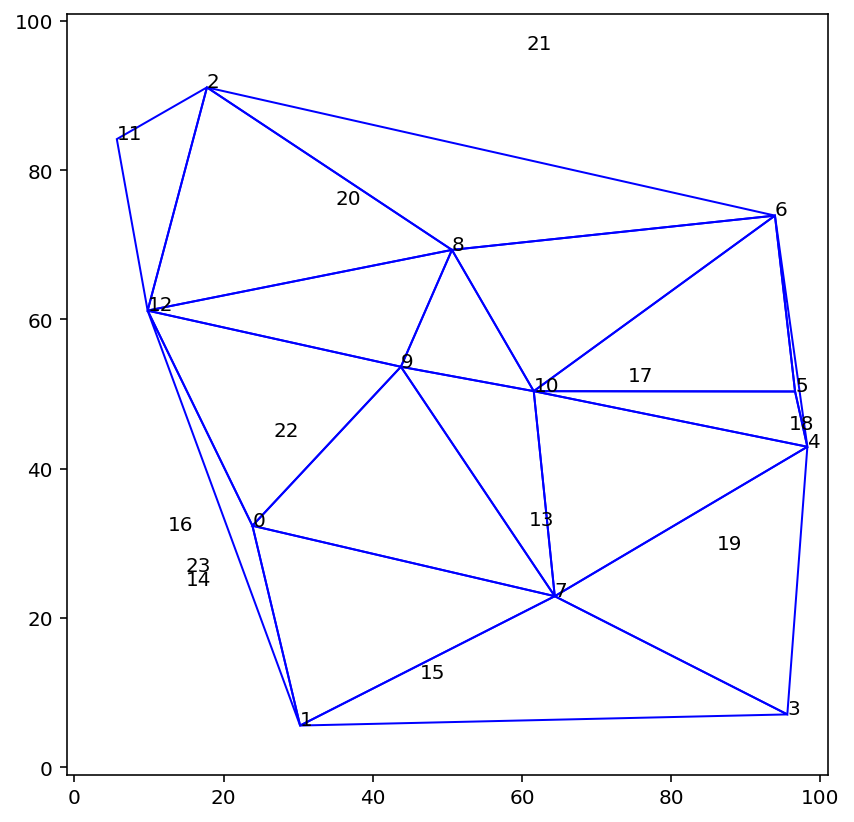

Inserting seed 13 [60.91885142 32.43932785]


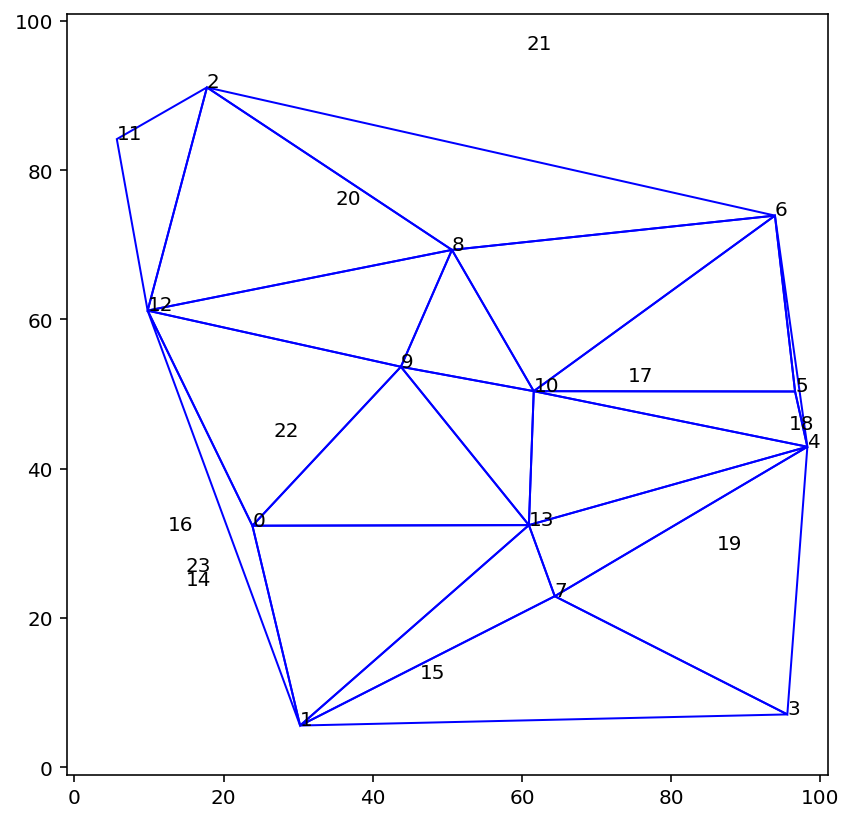

Inserting seed 14 [14.8965173  24.35091454]


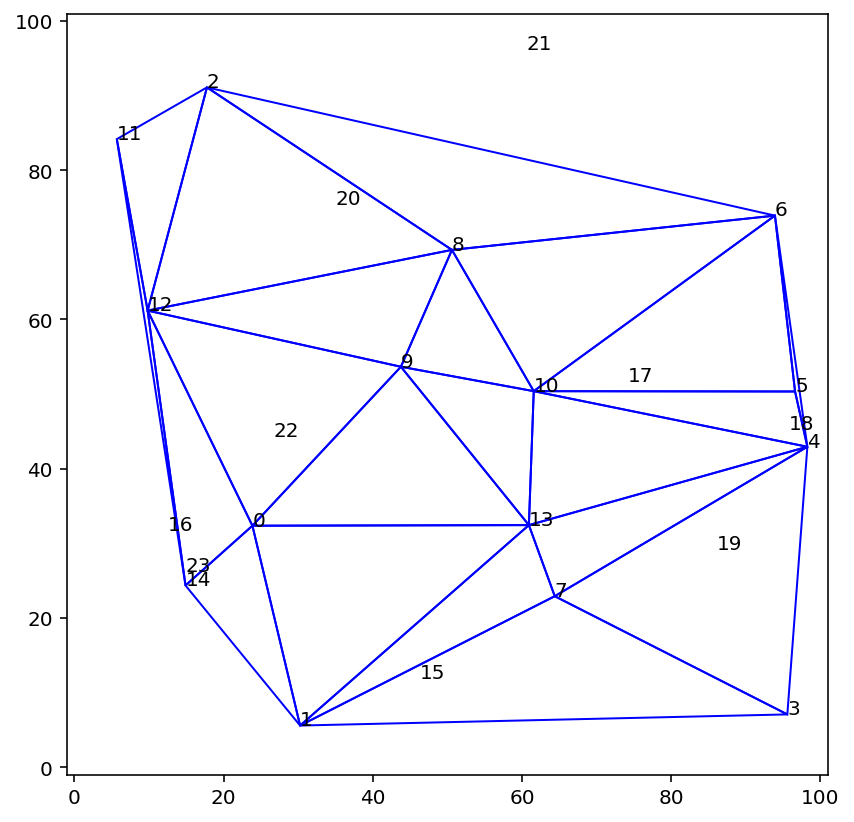

Inserting seed 15 [46.27450266 11.92077966]


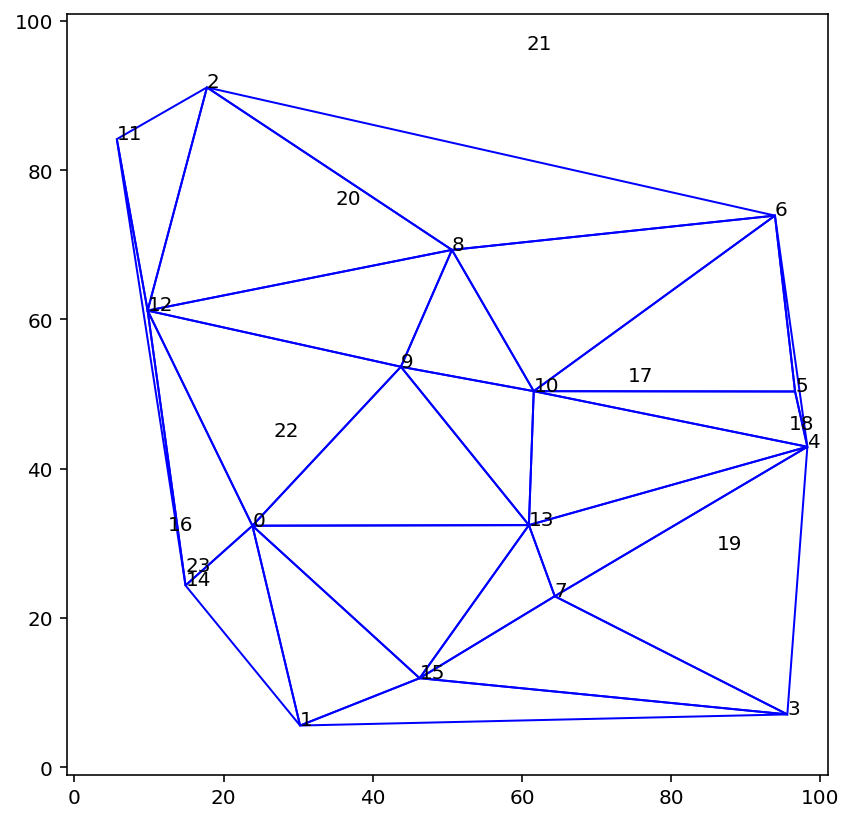

Inserting seed 16 [12.55682495 31.72886368]


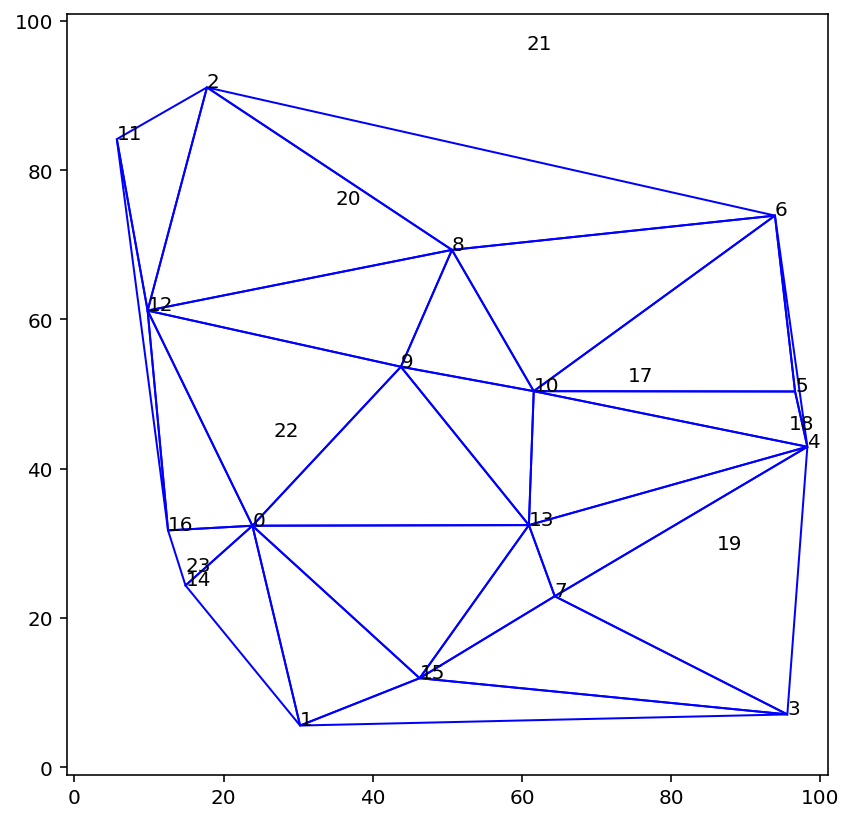

Inserting seed 17 [74.1189803 51.7306997]


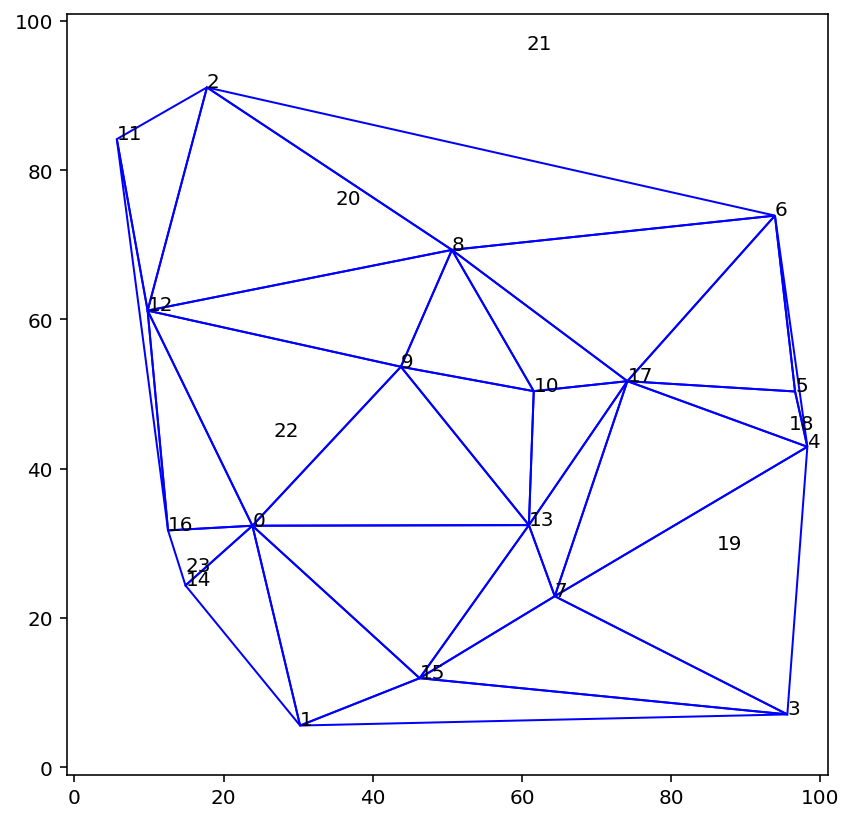

Inserting seed 18 [95.79677881 45.30946573]


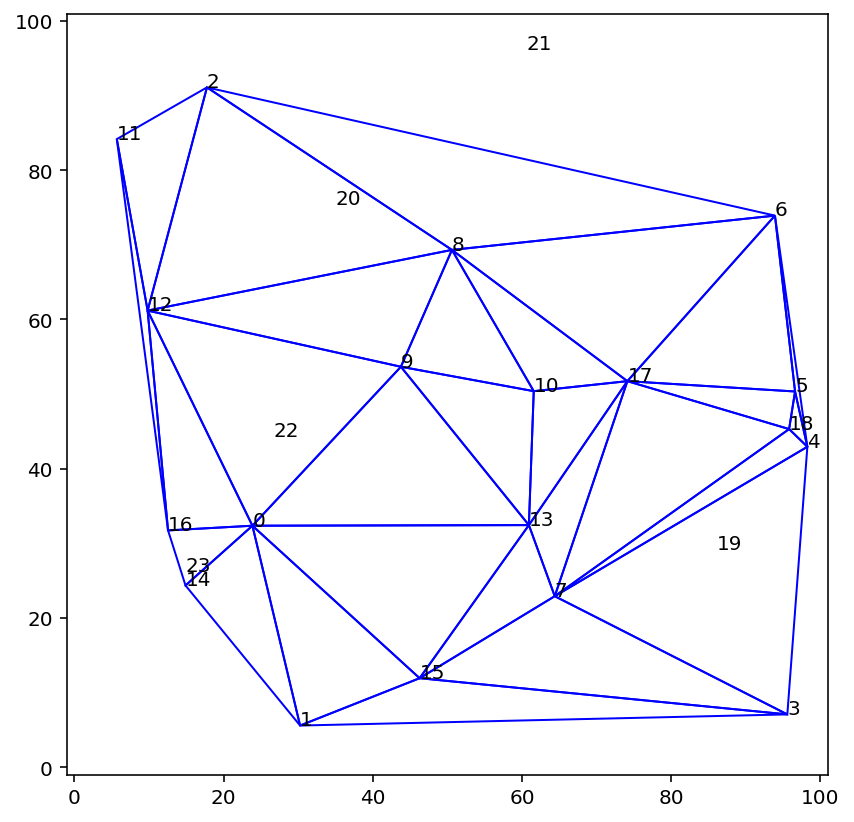

Inserting seed 19 [86.04768028 29.24224826]


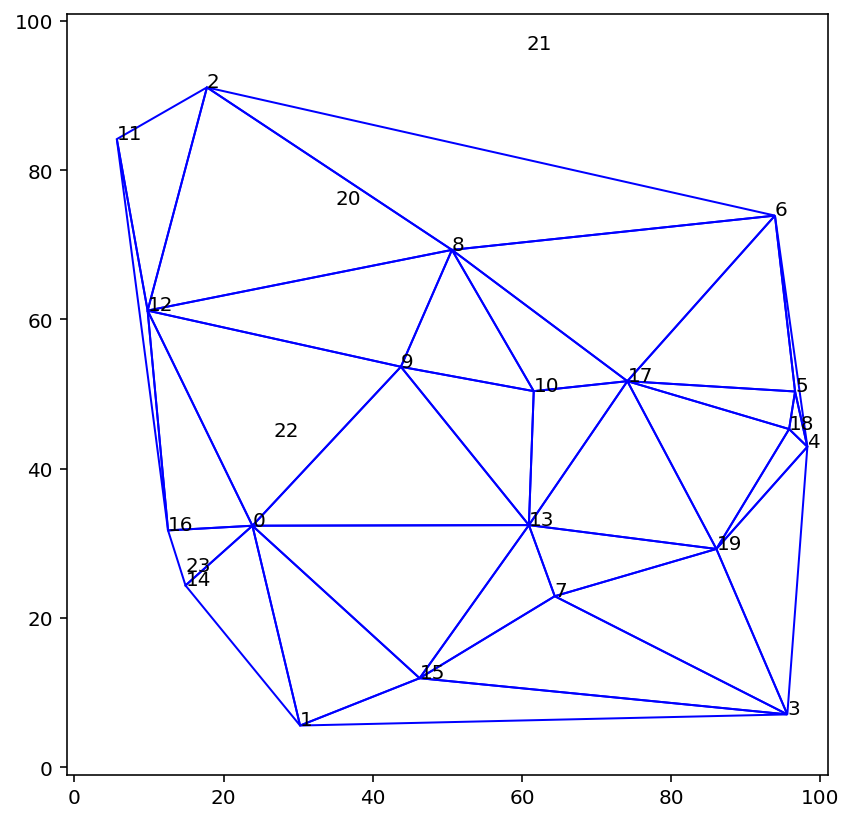

Inserting seed 20 [35.05952049 75.41718284]


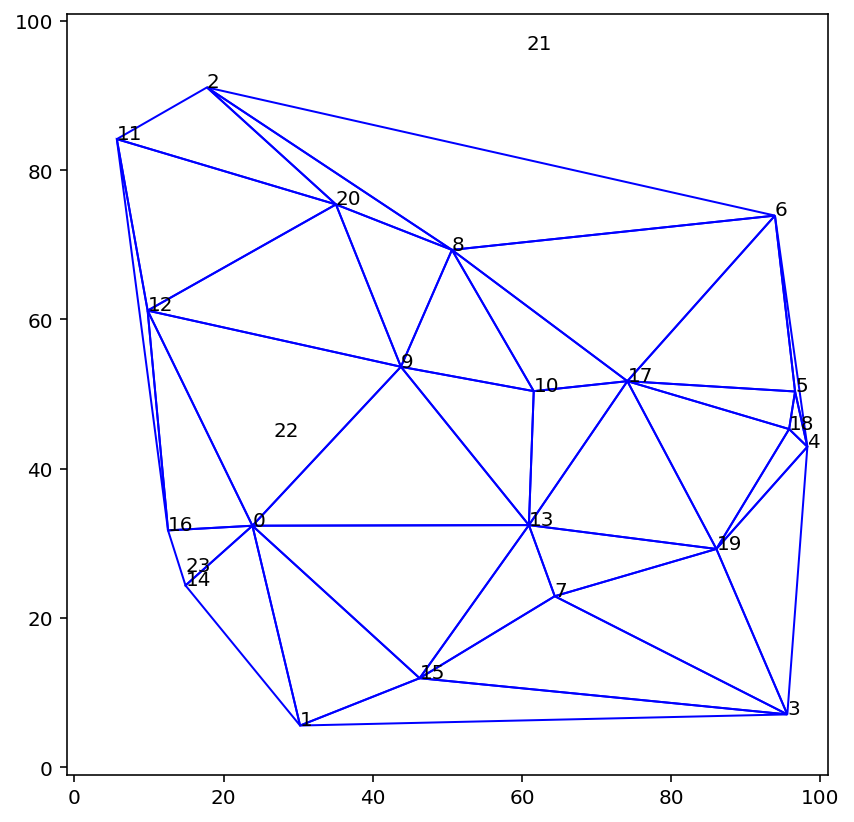

Inserting seed 21 [60.65314598 96.25206652]


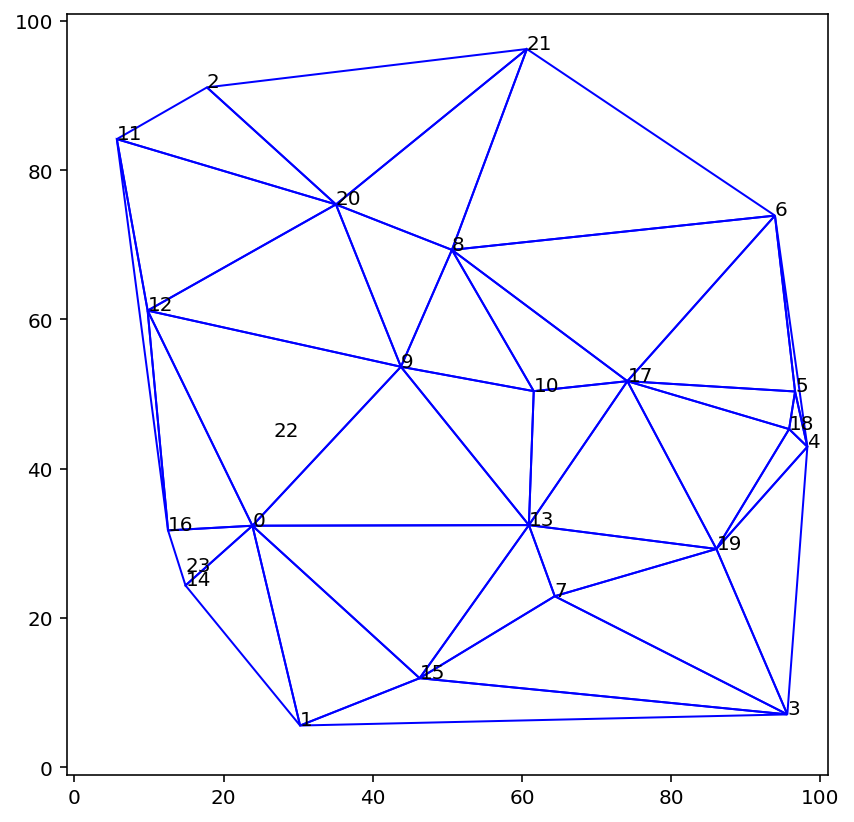

Inserting seed 22 [26.68587371 44.34332145]


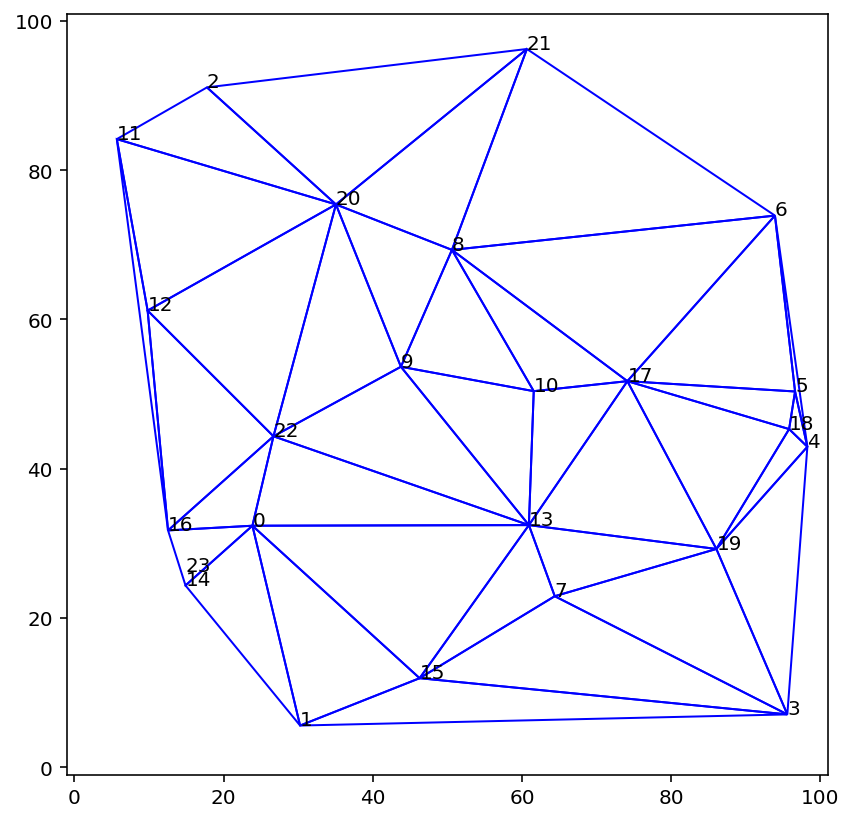

Inserting seed 23 [14.83257512 26.33437631]


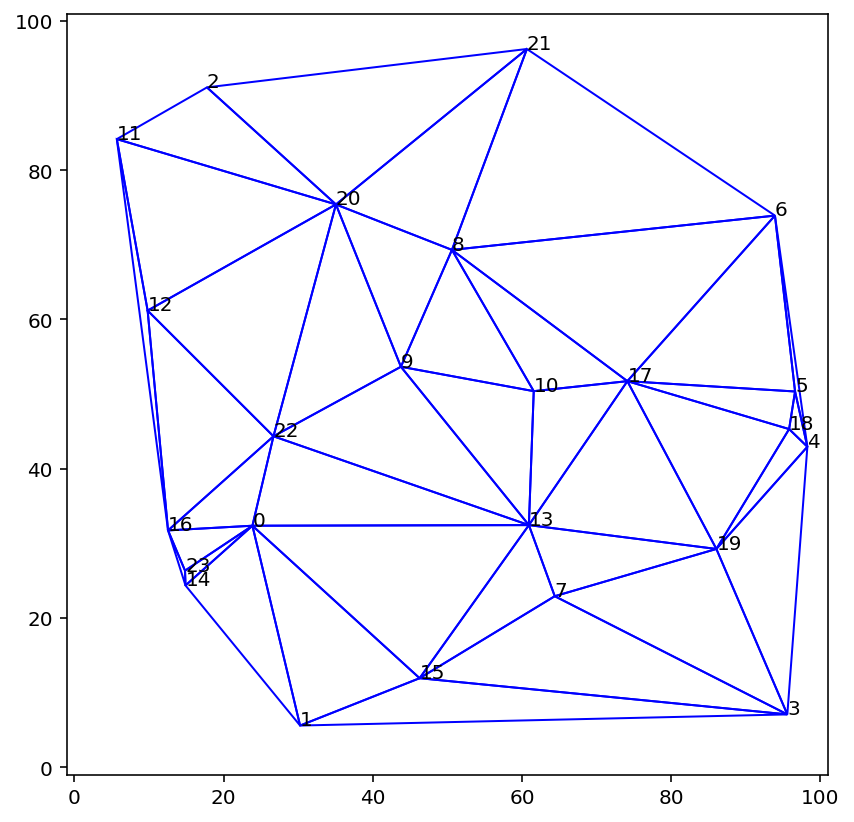

In [5]:
"""
Simple delaunay2D demo with mathplotlib
Written by Jose M. Espadero < http://github.com/jmespadero/pyDelaunay2D >
"""
import numpy as np

if __name__ == '__main__':

    ###########################################################
    # Generate 'numSeeds' random seeds in a square of size 'radius'
    numSeeds = 24
    radius = 100
    seeds = radius * np.random.random((numSeeds, 2))
    print("seeds:\n", seeds)
    print("BBox Min:", np.amin(seeds, axis=0),
          "Bbox Max: ", np.amax(seeds, axis=0))

    """
    Compute our Delaunay triangulation of seeds.
    """
    # It is recommended to build a frame taylored for our data
    # dt = D.Delaunay2D() # Default frame
    center = np.mean(seeds, axis=0)
    dt = Delaunay2D(center, 50 * radius)
    
    # Insert all seeds one by one
    for s in seeds:
        dt.addPoint(s)

    # Dump number of DT triangles
    print (len(dt.exportTriangles()), "Delaunay triangles")
       
    """
    Demostration of how to plot the data.
    """
    import matplotlib.pyplot as plt
    import matplotlib.tri
    import matplotlib.collections

    # Create a plot with matplotlib.pyplot
    fig, ax = plt.subplots()
    ax.margins(0.1)
    ax.set_aspect('equal')
    plt.axis([-1, radius+1, -1, radius+1])

    # Plot our Delaunay triangulation (plot in blue)
    cx, cy = zip(*seeds)
    dt_tris = dt.exportTriangles()
    ax.triplot(matplotlib.tri.Triangulation(cx, cy, dt_tris), 'bo--')

    # Plot annotated Delaunay vertex (seeds)
    for i, v in enumerate(seeds):
        plt.annotate(i, xy=v)
        
    # DEBUG: Use matplotlib to create a Delaunay triangulation (plot in green)
    # DEBUG: It should be equal to our result in dt_tris (plot in blue)
    # DEBUG: If boundary is diferent, try to increase the value of your margin
    # ax.triplot(matplotlib.tri.Triangulation(*zip(*seeds)), 'g--')
    
    # DEBUG: plot the extended triangulation (plot in red)
    # edt_coords, edt_tris = dt.exportExtendedDT()
    # edt_x, edt_y = zip(*edt_coords)
    # ax.triplot(matplotlib.tri.Triangulation(edt_x, edt_y, edt_tris), 'ro-.')

    # Plot the circumcircles (circles in black)
    for c, r in dt.exportCircles():
        ax.add_artist(plt.Circle(c, r, color='k', fill=False, ls='dotted'))
    
    # Build Voronoi diagram as a list of coordinates and regions
    vc, vr = dt.exportVoronoiRegions()
    
    # Plot annotated voronoi vertex
    plt.scatter([v[0] for v in vc], [v[1] for v in vc], marker='.')
    for i, v in enumerate(vc):
        plt.annotate(i, xy=v)
    
    # Plot annotated voronoi regions as filled polygons
    for r in vr:
        polygon = [vc[i] for i in vr[r]]     # Build polygon for each region
        plt.fill(*zip(*polygon), alpha=0.2)  # Plot filled polygon
        plt.annotate("r%d" % r, xy=np.average(polygon, axis=0))

    # Plot voronoi diagram edges (in red)
    for r in vr:
        polygon = [vc[i] for i in vr[r]]       # Build polygon for each region
        plt.plot(*zip(*polygon), color="red")  # Plot polygon edges in red
    
    # Dump plot to file
    # plt.savefig('output-delaunay2D.png', dpi=96)
    # plt.savefig('output-delaunay2D.svg', dpi=96)

    plt.show()

    # Plot a step-by-step triangulation
    # Starts from a new Delaunay2D frame
    dt2 = Delaunay2D(center, 50 * radius)    
    for i,s in enumerate(seeds):
        print("Inserting seed", i, s)
        dt2.addPoint(s)
        if i > 1:
            fig, ax = plt.subplots()
            ax.margins(0.1)
            ax.set_aspect('equal')
            plt.axis([-1, radius+1, -1, radius+1])            
            for i, v in enumerate(seeds):
                plt.annotate(i, xy=v)              # Plot all seeds
            for t in dt2.exportTriangles():
                polygon = [seeds[i] for i in t]     # Build polygon for each region
                plt.fill(*zip(*polygon), fill=False, color="b")  # Plot filled polygon
            plt.show()
            
            

In [10]:
print(*zip(*polygon))

(84.06989535271848, 98.45409497368776, 85.97558261585253) (55.70566419713975, 29.745527919163848, 69.6526688314192)


In [116]:
pointdelaunay = []
for t in dt2.exportTriangles():
    polygon = [seeds[i] for i in t]
    #print(polygon)
    pointdelaunay.append(polygon)
indicelist = []
pointlist = []
for i, v in enumerate(seeds):
    indicelist.append(v)
    pointlist.append(i)
    
dimension_delaunay = np.shape(pointdelaunay) 
nbre_triangle = dimension_delaunay[0]

dimension_seed = np.shape(seeds)
nbre_point = dimension_seed[0]
    
#print(*zip(pointlist,indicelist))
#print(seeds)
#print(point&index)
def voisin (listpoints,list_triangle) :
    voisin_list = []
    voisins = []
    dimension_delaunay = np.shape(pointdelaunay) 
    nbre_triangle = dimension_delaunay[0]
    dimension_seed = np.shape(seeds)
    nbre_point = dimension_seed[0]
    for i in range(nbre_point) :
        voisins = []
        a = []
        for k in range(nbre_triangle) :
            for j in range(3) :
                if np.array_equal(list_triangle[k][j],listpoints[i]) :
                    a = np.delete(list_triangle[k],j)
                    voisins.append(a)
        voisin_list.append(voisins)
    return voisin_list    

    
    
    
print(seeds)
print(pointdelaunay)
print("!")
print(voisin(seeds,pointdelaunay))
            
#print(*zip(pointlist,indicelist))

[[81.24672579 13.431985  ]
 [38.63519833 95.07322312]
 [68.1868628  33.66008041]
 [64.18903124 51.95124725]
 [89.98474066 55.01590434]
 [42.8526574  82.4791291 ]
 [62.30190021  1.99898364]
 [67.82870554 83.14395836]
 [44.10066085 70.94689827]
 [54.73693595 17.68756153]
 [68.98320142 53.13130853]
 [37.95903107 67.15455817]
 [78.82523842 70.38400149]
 [ 2.25343198 62.23964189]
 [75.53366185 84.40020367]
 [59.31110533 12.74478277]
 [47.57028942 19.51947519]
 [78.64059168 21.52805967]
 [88.2131591  34.66675861]
 [51.74995743 88.10302267]
 [82.48285731  3.65384385]
 [49.04770534 46.59432246]
 [27.47129962 10.46704423]
 [74.10042731 50.9720318 ]]
[[array([44.10066085, 70.94689827]), array([64.18903124, 51.95124725]), array([67.82870554, 83.14395836])], [array([68.98320142, 53.13130853]), array([67.82870554, 83.14395836]), array([64.18903124, 51.95124725])], [array([37.95903107, 67.15455817]), array([44.10066085, 70.94689827]), array([42.8526574, 82.4791291])], [array([37.95903107, 67.1545581

[0, 1, 2]
